README.md contains a description of the code as well as information on runtime and specs.

## 1. Download and visualise nodes and edges from TfL Unified API

### (a) Download data

In [1]:
import requests
import networkx as nx
from math import radians, sin, cos, asin, sqrt
import math
import random

# Set seed for reproducibility
random.seed(42)  # choose any integer you like

API_KEY = "b982204c1823447380d54d6095e29384"
headers = {"Ocp-Apim-Subscription-Key": API_KEY}

# Get all Tube lines

lines_url = "https://api.tfl.gov.uk/Line/Mode/tube"
lines_resp = requests.get(lines_url, headers=headers, timeout=60)
print("Lines status:", lines_resp.status_code)
lines_data = lines_resp.json() if lines_resp.status_code == 200 else None

if lines_data is None:
    raise RuntimeError("Failed to get Tube lines")

# Extract line IDs
tube_line_ids = [ln["id"] for ln in lines_data]
print("Tube lines:", tube_line_ids)

# Download route sequences per line & direction

def get_route_sequence(line_id, direction):
    url = f"https://api.tfl.gov.uk/Line/{line_id}/Route/Sequence/{direction}"
    resp = requests.get(url, headers=headers, timeout=60)
    if resp.status_code != 200:
        print(f"Failed for {line_id} {direction}: {resp.status_code}")
        return None
    return resp.json()

# Build graph G from stopPointSequence

G = nx.Graph()

def euclidean_distance(lat1, lon1, lat2, lon2):
    # Straight-line distance in degrees
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    return math.sqrt(dlat**2 + dlon**2) * 111.0 # One degree is roughly 111km (https://www.johndcook.com/how_big_is_a_degree.html)

def add_edge_if_valid(u, v, attrs_u, attrs_v):
    if u == v:
        return
    if u not in G:
        G.add_node(u, **attrs_u)
    if v not in G:
        G.add_node(v, **attrs_v)
    if not G.has_edge(u, v):
        lat1, lon1 = attrs_u["lat"], attrs_u["lon"]
        lat2, lon2 = attrs_v["lat"], attrs_v["lon"]
        d = euclidean_distance(lat1, lon1, lat2, lon2)
        G.add_edge(u, v, weight=d)

total_edges = 0

for line_id in tube_line_ids:
    for direction in ["inbound", "outbound"]:
        data = get_route_sequence(line_id, direction)
        if data is None:
            continue

        # data has 'stopPointSequences' (list of branches)
        seqs = data.get("stopPointSequences", [])
        for seq in seqs:
            stops = seq.get("stopPoint", [])
            # build edges between consecutive stops
            for i in range(len(stops) - 1):
                s1, s2 = stops[i], stops[i+1]

                # each stop has id, name, lat, lon
                id1 = s1.get("id")
                id2 = s2.get("id")
                if not id1 or not id2:
                    continue

                attrs1 = {
                    "name": s1.get("name"),
                    "lat": s1.get("lat"),
                    "lon": s1.get("lon"),
                    "modes": s1.get("modes"),
                }
                attrs2 = {
                    "name": s2.get("name"),
                    "lat": s2.get("lat"),
                    "lon": s2.get("lon"),
                    "modes": s2.get("modes"),
                }

                if attrs1["lat"] is None or attrs1["lon"] is None:
                    continue
                if attrs2["lat"] is None or attrs2["lon"] is None:
                    continue

                add_edge_if_valid(id1, id2, attrs1, attrs2)
                total_edges += 1

print("Final nodes:", G.number_of_nodes())
print("Final edges:", G.number_of_edges())
print("Sample nodes:", list(G.nodes(data=True))[:5])
print("Sample edges:", list(G.edges(data=True))[:10])

Lines status: 200
Tube lines: ['bakerloo', 'central', 'circle', 'district', 'hammersmith-city', 'jubilee', 'metropolitan', 'northern', 'piccadilly', 'victoria', 'waterloo-city']
Final nodes: 272
Final edges: 314
Sample nodes: [('940GZZLUHAW', {'name': 'Harrow & Wealdstone Underground Station', 'lat': 51.592268, 'lon': -0.335217, 'modes': ['tube']}), ('940GZZLUKEN', {'name': 'Kenton Underground Station', 'lat': 51.581756, 'lon': -0.31691, 'modes': ['tube']}), ('940GZZLUSKT', {'name': 'South Kenton Underground Station', 'lat': 51.570232, 'lon': -0.308433, 'modes': ['tube']}), ('940GZZLUNWY', {'name': 'North Wembley Underground Station', 'lat': 51.562551, 'lon': -0.304, 'modes': ['tube']}), ('940GZZLUWYC', {'name': 'Wembley Central Underground Station', 'lat': 51.552304, 'lon': -0.296852, 'modes': ['tube']})]
Sample edges: [('940GZZLUHAW', '940GZZLUKEN', {'weight': 2.343252835302371}), ('940GZZLUKEN', '940GZZLUSKT', {'weight': 1.587967819480422}), ('940GZZLUSKT', '940GZZLUNWY', {'weight':

### (b) Visualise the (undirected) Tube map

Nodes: 272
Edges: 314
Nodes and edges information used in Section 4: Base Case.


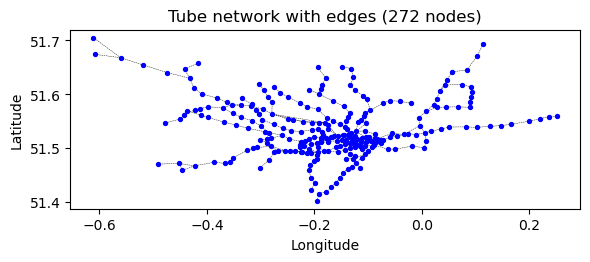

The figure above corresponds to Figure 1 in the report.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

print("Nodes and edges information used in Section 4: Base Case.")

# Take all nodes
sub_nodes = list(G.nodes())
sub_G = G.subgraph(sub_nodes)

lats = [G.nodes[n]["lat"] for n in sub_nodes]
lons = [G.nodes[n]["lon"] for n in sub_nodes]

plt.figure(figsize=(6, 3))

# Draw edges as dashed grey lines
for u, v in sub_G.edges():
    lat1, lon1 = G.nodes[u]["lat"], G.nodes[u]["lon"]
    lat2, lon2 = G.nodes[v]["lat"], G.nodes[v]["lon"]
    plt.plot(
        [lon1, lon2],
        [lat1, lat2],
        color="black",
        linewidth=0.3,
        linestyle="--",
        zorder=1,
    )

# Draw nodes on top
plt.scatter(lons, lats, s=8, c="blue", zorder=2)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Tube network with edges ({len(sub_nodes)} nodes)")
plt.gca().set_aspect("equal", "box")
plt.tight_layout()
plt.show()

print("The figure above corresponds to Figure 1 in the report.")

## 2. Analyse the complete Tube map

- Check for the efficiency of the Tube if its five most important stations are removed
- And if five random stations are removed

Calculate average shortest path length and betweenness centrality for the Tube map

In [3]:
# 1. Basic connectivity check
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

G_base = G # All nodes are connected in the London Underground

# 2. Average shortest path length (Dijkstra's Alogoritm)
asp = nx.average_shortest_path_length(G_base, weight="weight") # weight argument ensures that path is calculated by distance
print("Baseline average shortest path length (km):", round(asp,2))
print("Average shortest path statistic used in Section 4: Questions 2 and 3.")

# 3. Betweenness centrality (identifies 'important' stations)
bet = nx.betweenness_centrality(G_base, weight="weight", normalized=True)
# sort by centrality
top_5 = sorted(bet.items(), key=lambda x: x[1], reverse=True)[:5]

print("\nTop 5 stations by betweenness centrality:")
for node_id, score in top_5:
    name = G_base.nodes[node_id].get("name", node_id)
    print(f"{name} ({node_id}): {score:.4f}")

print("\nTop 5 stations list used in Section 4: Question 1.")

Nodes: 272
Edges: 314
Baseline average shortest path length (km): 26.18
Average shortest path statistic used in Section 4: Questions 2 and 3.

Top 5 stations by betweenness centrality:
Baker Street Underground Station (940GZZLUBST): 0.3192
King's Cross St. Pancras Underground Station (940GZZLUKSX): 0.2578
Liverpool Street Underground Station (940GZZLULVT): 0.2554
Aldgate East Underground Station (940GZZLUADE): 0.2448
Whitechapel Underground Station (940GZZLUWPL): 0.2396

Top 5 stations list used in Section 4: Question 1.


Stress test the Tube by removing the top 5 stations and 5 random stations

In [4]:
critical_nodes = []
for node_id, score in top_5:
    name = G_base.nodes[node_id].get("name", node_id)
    critical_nodes.append(node_id)
    print(f"{name} ({node_id}): {score:.4f}")

# Remove top 5 and recompute metrics

G_targeted = G_base.copy()
G_targeted.remove_nodes_from(critical_nodes)

# Work on largest remaining component
if nx.is_connected(G_targeted):
    Gt = G_targeted
else:
    Gt = G_targeted.subgraph(max(nx.connected_components(G_targeted), key=len)).copy()

tgt_asp = nx.average_shortest_path_length(Gt, weight="weight")
tgt_lcc_size = len(max(nx.connected_components(G_targeted), key=len))

print("\nAfter targeted removal (top 5 betweenness):")
print("Largest component size:", round(tgt_lcc_size,2))
print("Average shortest path (km):", round(tgt_asp,2))

# Remove 5 random distinct stations

all_nodes = list(G_base.nodes())
rand_nodes = random.sample(all_nodes, 5)

G_random = G_base.copy()
G_random.remove_nodes_from(rand_nodes)

if nx.is_connected(G_random):
    Gr = G_random
else:
    Gr = G_random.subgraph(max(nx.connected_components(G_random), key=len)).copy()

rnd_asp = nx.average_shortest_path_length(Gr, weight="weight")
rnd_lcc_size = len(max(nx.connected_components(G_random), key=len))

print("\nAfter random removal (5 random stations):")
print("Removed nodes:", [G_base.nodes[n].get('name', n) for n in rand_nodes])
print("Largest component size:", round(rnd_lcc_size,2))
print("Average shortest path (km):", round(rnd_asp,2))

print("\nAverage shortest path after removing top 5 nodes and random 5 nodes used in Section 4: Questions 2 and 3.")
print("List of random stations removed used in Section 4: Question 3.")

Baker Street Underground Station (940GZZLUBST): 0.3192
King's Cross St. Pancras Underground Station (940GZZLUKSX): 0.2578
Liverpool Street Underground Station (940GZZLULVT): 0.2554
Aldgate East Underground Station (940GZZLUADE): 0.2448
Whitechapel Underground Station (940GZZLUWPL): 0.2396

After targeted removal (top 5 betweenness):
Largest component size: 248
Average shortest path (km): 32.44

After random removal (5 random stations):
Removed nodes: ['Northolt Underground Station', 'Warwick Avenue Underground Station', 'Southfields Underground Station', 'Hammersmith (Dist&Picc Line) Underground Station', 'Upton Park Underground Station']
Largest component size: 240
Average shortest path (km): 25.38

Average shortest path after removing top 5 nodes and random 5 nodes used in Section 4: Questions 2 and 3.
List of random stations removed used in Section 4: Question 3.


Visualise the splintered map after top five tube stations and random five tube stations are removed

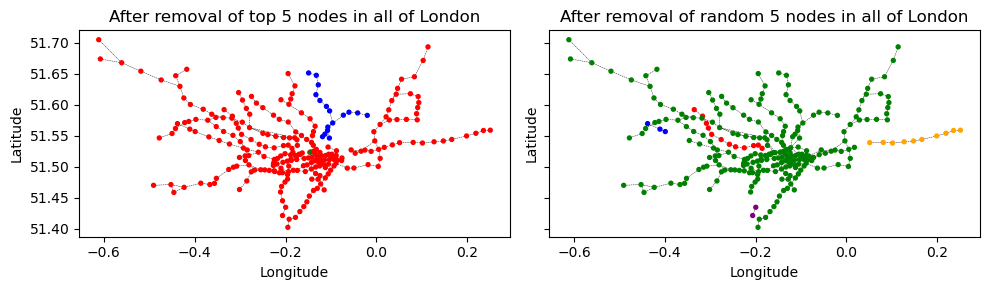

Graph displayed in Figure 3 in the report.


In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)

# Targeted removal plot
sub_nodes_t = list(G_targeted.nodes())
sub_G_t = G_targeted.subgraph(sub_nodes_t)

lats_t = [G_targeted.nodes[n]["lat"] for n in sub_nodes_t]
lons_t = [G_targeted.nodes[n]["lon"] for n in sub_nodes_t]

components_t = list(nx.connected_components(sub_G_t))
base_colors = ["red", "green", "blue", "orange", "purple",
               "brown", "pink", "gray", "olive", "cyan"]

node_to_color_t = {}
for i, comp in enumerate(components_t):
    color = base_colors[i % len(base_colors)]
    for n in comp:
        node_to_color_t[n] = color

colors_t = [node_to_color_t[n] for n in sub_nodes_t]

# Draw edges
for u, v in sub_G_t.edges():
    lat1, lon1 = G_targeted.nodes[u]["lat"], G_targeted.nodes[u]["lon"]
    lat2, lon2 = G_targeted.nodes[v]["lat"], G_targeted.nodes[v]["lon"]
    ax1.plot(
        [lon1, lon2],
        [lat1, lat2],
        color="black",
        linewidth=0.3,
        linestyle="--",
        zorder=1,
    )

# Draw nodes
ax1.scatter(lons_t, lats_t, s=8, c=colors_t, zorder=2)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title(f"After removal of top 5 nodes in all of London")

# Random removal plot
sub_nodes_r = list(G_random.nodes())
sub_G_r = G_random.subgraph(sub_nodes_r)

lats_r = [G_random.nodes[n]["lat"] for n in sub_nodes_r]
lons_r = [G_random.nodes[n]["lon"] for n in sub_nodes_r]

components_r = list(nx.connected_components(sub_G_r))

node_to_color_r = {}
for i, comp in enumerate(components_r):
    color = base_colors[i % len(base_colors)]
    for n in comp:
        node_to_color_r[n] = color

colors_r = [node_to_color_r[n] for n in sub_nodes_r]

# Draw edges
for u, v in sub_G_r.edges():
    lat1, lon1 = G_random.nodes[u]["lat"], G_random.nodes[u]["lon"]
    lat2, lon2 = G_random.nodes[v]["lat"], G_random.nodes[v]["lon"]
    ax2.plot(
        [lon1, lon2],
        [lat1, lat2],
        color="black",
        linewidth=0.3,
        linestyle="--",
        zorder=1,
    )

# Draw nodes
ax2.scatter(lons_r, lats_r, s=8, c=colors_r, zorder=2)
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title(f"After removal of random 5 nodes in all of London")

plt.tight_layout()
plt.show()

print("Graph displayed in Figure 3 in the report.")

Run the Girvan-Newman algorithm to check whether the top 5 stations lie between communities.

In [6]:
comp_generator = nx.community.girvan_newman(G_base)

# First community split (2 communities)
communities_level1 = next(comp_generator)

# Second split (3 communities)
communities_level2 = next(comp_generator)

# Third split (4 communities)
communities_level3 = next(comp_generator)

print("Level 1:", [len(c) for c in communities_level1])
print("Level 2:", [len(c) for c in communities_level2])
print("Level 3:", [len(c) for c in communities_level3])

Level 1: [193, 79]
Level 2: [27, 166, 79]
Level 3: [27, 113, 53, 79]


Run the Girvan-Newman algorithm to check whether the random 5 stations lie between communities.

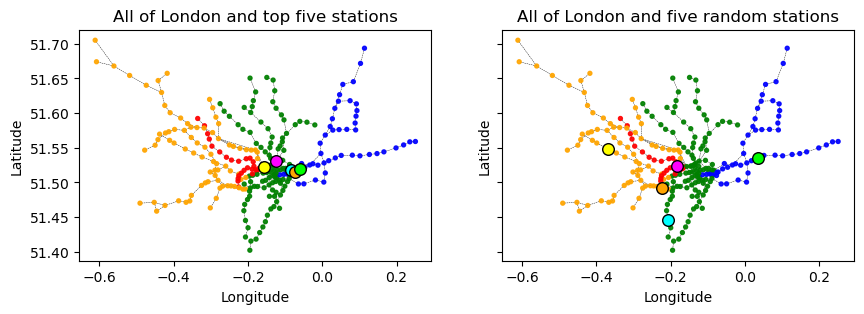

Graph used in Figure 5 in the report.


In [7]:
# Girvan–Newman communities (level 3)
communities = communities_level3

comm_index = {}
for i, comm in enumerate(communities):
    for n in comm:
        comm_index[n] = i

palette = ["red", "green", "blue", "orange", "purple", "cyan"]
node_colors = [palette[comm_index[n] % len(palette)] for n in G_base.nodes()]

pos = {n: (G_base.nodes[n]["lon"], G_base.nodes[n]["lat"]) for n in G_base.nodes()}

xs = [pos[n][0] for n in G_base.nodes()]
ys = [pos[n][1] for n in G_base.nodes()]

top5_nodes = [n for n, _ in top_5]
rand_nodes_gn = rand_nodes
top5_colors = ["yellow", "magenta", "cyan", "orange", "lime"]

# Create side‑by‑side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)

# 1. Top‑5 betweenness
for u, v in G_base.edges():
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    ax1.plot([x1, x2], [y1, y2],
             color="black", linewidth=0.3, linestyle="--", zorder=1)

ax1.scatter(xs, ys, s=8, c=node_colors, zorder=2, alpha=0.9)

handles1, labels1 = [], []
for node, color in zip(top5_nodes, top5_colors):
    x, y = pos[node]
    label = G_base.nodes[node].get("name", str(node))
    h = ax1.scatter(
        [x], [y],
        s=70, c=color,
        edgecolors="black", linewidths=1,
        zorder=3, label=label,
    )
    handles1.append(h)
    labels1.append(label)

ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title("All of London and top five stations")
ax1.set_aspect("auto")

# 2. Random‑5
for u, v in G_base.edges():
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    ax2.plot([x1, x2], [y1, y2],
             color="black", linewidth=0.3, linestyle="--", zorder=1)

ax2.scatter(xs, ys, s=8, c=node_colors, zorder=2, alpha=0.9)

handles2, labels2 = [], []
for node, color in zip(rand_nodes_gn, top5_colors):
    x, y = pos[node]
    label = G_base.nodes[node].get("name", str(node))
    h = ax2.scatter(
        [x], [y],
        s=70, c=color,
        edgecolors="black", linewidths=1,
        zorder=3, label=label,
    )
    handles2.append(h)
    labels2.append(label)

ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title("All of London and five random stations")
ax2.set_aspect("auto")

plt.show()

print("Graph used in Figure 5 in the report.")

## 3. Rerun for central London

Bound the Tube map by longitude and latitude to approximate stations that are in zones 1 and 2 (central London).

Central nodes: 133
Central edges: 167
Nodes and edges information used in Section 4: Base Case.


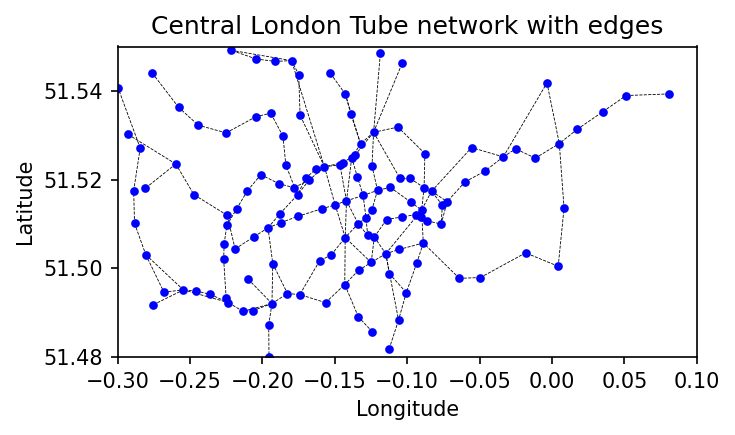

Graph used in Figure 2 in the report.
Bounding box information used in Section 4: Base Case.


In [8]:
# Choose the bounding box for "central London"
LON_MIN, LON_MAX = -0.30, 0.10
LAT_MIN, LAT_MAX = 51.48, 51.55

# Select nodes inside the box
central_nodes = [
    n for n, d in G.nodes(data=True)
    if (LON_MIN <= d["lon"] <= LON_MAX) and (LAT_MIN <= d["lat"] <= LAT_MAX)
]

print("Central nodes:", len(central_nodes))

# Create subgraph on those nodes
G_central = G.subgraph(central_nodes).copy()
print("Central edges:", G_central.number_of_edges())
print("Nodes and edges information used in Section 4: Base Case.")

# Extract coordinates
lats = [G_central.nodes[n]["lat"] for n in G_central.nodes()]
lons = [G_central.nodes[n]["lon"] for n in G_central.nodes()]

# Visualise the bounded area
plt.figure(figsize=(5, 3), dpi=150)

for u, v in G_central.edges():
    lat1, lon1 = G_central.nodes[u]["lat"], G_central.nodes[u]["lon"]
    lat2, lon2 = G_central.nodes[v]["lat"], G_central.nodes[v]["lon"]
    plt.plot(
        [lon1, lon2],
        [lat1, lat2],
        color="black",
        linewidth=0.4,
        linestyle="--",
        zorder=1,
    )

plt.scatter(lons, lats, s=10, c="blue", zorder=2)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Central London Tube network with edges")

# Use the actual bounds
plt.xlim(LON_MIN, LON_MAX)
plt.ylim(LAT_MIN, LAT_MAX)

# Relax aspect
plt.gca().set_aspect("auto")

plt.tight_layout()
plt.show()
print("Graph used in Figure 2 in the report.")
print("Bounding box information used in Section 4: Base Case.")

In [9]:
# 1. Basic connectivity check
print("Nodes:", G_central.number_of_nodes())
print("Edges:", G_central.number_of_edges())

# 2. Average shortest path length (Dijkstra's Alogoritm)
asp = nx.average_shortest_path_length(G_central, weight="weight")
print("Baseline average shortest path length (km):", round(asp, 2))
print("Average shortest path statistic used in Section 4: Questions 2 and 3.")

# 3. Betweenness centrality (identifies 'important' stations)
bet = nx.betweenness_centrality(G_central, weight="weight", normalized=True)
# sort by centrality
top_5 = sorted(bet.items(), key=lambda x: x[1], reverse=True)[:5]

print("\nTop 5 stations by betweenness centrality:")
for node_id, score in top_5:
    name = G_central.nodes[node_id].get("name", node_id)
    print(f"{name} ({node_id}): {score:.4f}")
print("\nTop 5 stations used in Section 4: Base Case.")

Nodes: 133
Edges: 167
Baseline average shortest path length (km): 12.41
Average shortest path statistic used in Section 4: Questions 2 and 3.

Top 5 stations by betweenness centrality:
Baker Street Underground Station (940GZZLUBST): 0.2992
Edgware Road (Circle Line) Underground Station (940GZZLUERC): 0.2595
Oxford Circus Underground Station (940GZZLUOXC): 0.2402
Bond Street Underground Station (940GZZLUBND): 0.2339
Earl's Court Underground Station (940GZZLUECT): 0.2194

Top 5 stations used in Section 4: Base Case.


In [10]:
critical_nodes = []
for node_id, score in top_5:
    name = G_central.nodes[node_id].get("name", node_id)
    critical_nodes.append(node_id)
    print(f"{name} ({node_id}): {score:.4f}") # Remove top 5 and recompute metrics

G_targeted = G_central.copy()
G_targeted.remove_nodes_from(critical_nodes)

# Work on largest remaining component
if nx.is_connected(G_targeted):
    Gt = G_targeted
else:
    Gt = G_targeted.subgraph(max(nx.connected_components(G_targeted), key=len)).copy()

tgt_asp = nx.average_shortest_path_length(Gt, weight="weight")
tgt_lcc_size = len(max(nx.connected_components(G_targeted), key=len))

print("\nAfter targeted removal (top 5 betweenness):")
print("Largest component size:", round(tgt_lcc_size,2))
print("Average shortest path (km):", round(tgt_asp,2))

# Remove 5 random distinct stations

all_nodes = list(G_central.nodes())
rand_nodes = random.sample(all_nodes, 5)

G_random = G_central.copy()
G_random.remove_nodes_from(rand_nodes)

if nx.is_connected(G_random):
    Gr = G_random
else:
    Gr = G_random.subgraph(max(nx.connected_components(G_random), key=len)).copy()

rnd_asp = nx.average_shortest_path_length(Gr, weight="weight")
rnd_lcc_size = len(max(nx.connected_components(G_random), key=len))

print("\nAfter random removal (5 random stations):")
print("Removed nodes:", [G_central.nodes[n].get('name', n) for n in rand_nodes])
print("Largest component size:", round(rnd_lcc_size,2))
print("Average shortest path (km):", round(rnd_asp,2))

print("\nAverage shortest path after removing top 5 and random 5 nodes used in Section 4: Questions 2 and 3.")

Baker Street Underground Station (940GZZLUBST): 0.2992
Edgware Road (Circle Line) Underground Station (940GZZLUERC): 0.2595
Oxford Circus Underground Station (940GZZLUOXC): 0.2402
Bond Street Underground Station (940GZZLUBND): 0.2339
Earl's Court Underground Station (940GZZLUECT): 0.2194

After targeted removal (top 5 betweenness):
Largest component size: 96
Average shortest path (km): 12.4

After random removal (5 random stations):
Removed nodes: ['Temple Underground Station', 'North Greenwich Underground Station', 'Aldgate Underground Station', "Earl's Court Underground Station", 'Hammersmith (H&C Line) Underground Station']
Largest component size: 112
Average shortest path (km): 11.29

Average shortest path after removing top 5 and random 5 nodes used in Section 4: Questions 2 and 3.


Visualise the splintered map after top five tube stations are removed

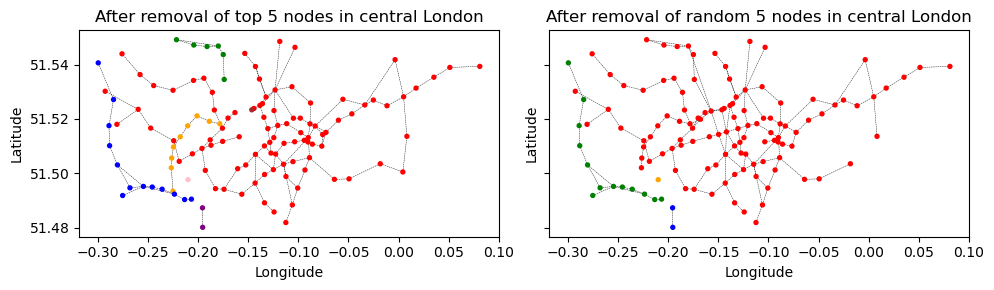

Graph used in Figure 4 of the report.


In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)

# Targeted removal plot
sub_nodes_t = list(G_targeted.nodes())
sub_G_t = G_targeted.subgraph(sub_nodes_t)

lats_t = [G_targeted.nodes[n]["lat"] for n in sub_nodes_t]
lons_t = [G_targeted.nodes[n]["lon"] for n in sub_nodes_t]

components_t = list(nx.connected_components(sub_G_t))
base_colors = ["red", "green", "blue", "orange", "purple",
               "brown", "pink", "gray", "olive", "cyan"]

node_to_color_t = {}
for i, comp in enumerate(components_t):
    color = base_colors[i % len(base_colors)]
    for n in comp:
        node_to_color_t[n] = color

colors_t = [node_to_color_t[n] for n in sub_nodes_t]

# Draw edges
for u, v in sub_G_t.edges():
    lat1, lon1 = G_targeted.nodes[u]["lat"], G_targeted.nodes[u]["lon"]
    lat2, lon2 = G_targeted.nodes[v]["lat"], G_targeted.nodes[v]["lon"]
    ax1.plot(
        [lon1, lon2],
        [lat1, lat2],
        color="black",
        linewidth=0.3,
        linestyle="--",
        zorder=1,
    )

# Draw nodes
ax1.scatter(lons_t, lats_t, s=8, c=colors_t, zorder=2)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title(f"After removal of top 5 nodes in central London")

# Random removal plot
sub_nodes_r = list(G_random.nodes())
sub_G_r = G_random.subgraph(sub_nodes_r)

lats_r = [G_random.nodes[n]["lat"] for n in sub_nodes_r]
lons_r = [G_random.nodes[n]["lon"] for n in sub_nodes_r]

components_r = list(nx.connected_components(sub_G_r))

node_to_color_r = {}
for i, comp in enumerate(components_r):
    color = base_colors[i % len(base_colors)]
    for n in comp:
        node_to_color_r[n] = color

colors_r = [node_to_color_r[n] for n in sub_nodes_r]

# Draw edges
for u, v in sub_G_r.edges():
    lat1, lon1 = G_random.nodes[u]["lat"], G_random.nodes[u]["lon"]
    lat2, lon2 = G_random.nodes[v]["lat"], G_random.nodes[v]["lon"]
    ax2.plot(
        [lon1, lon2],
        [lat1, lat2],
        color="black",
        linewidth=0.3,
        linestyle="--",
        zorder=1,
    )

# Draw nodes
ax2.scatter(lons_r, lats_r, s=8, c=colors_r, zorder=2)
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title(f"After removal of random 5 nodes in central London")

plt.tight_layout()
plt.show()

print("Graph used in Figure 4 of the report.")

Run the Girvan-Newman algorithm to check whether the top 5 stations lie between communities.

In [12]:
comp_generator = nx.community.girvan_newman(G_base)

# First community split (2 communities)
communities_level1 = next(comp_generator)

# Second split (3 communities)
communities_level2 = next(comp_generator)

# Third split (4 communities)
communities_level3 = next(comp_generator)

print("Level 1:", [len(c) for c in communities_level1])
print("Level 2:", [len(c) for c in communities_level2])
print("Level 3:", [len(c) for c in communities_level3])

Level 1: [193, 79]
Level 2: [27, 166, 79]
Level 3: [27, 113, 53, 79]


Run the Girvan-Newman algorithm to check whether the random 5 stations lie between communities.

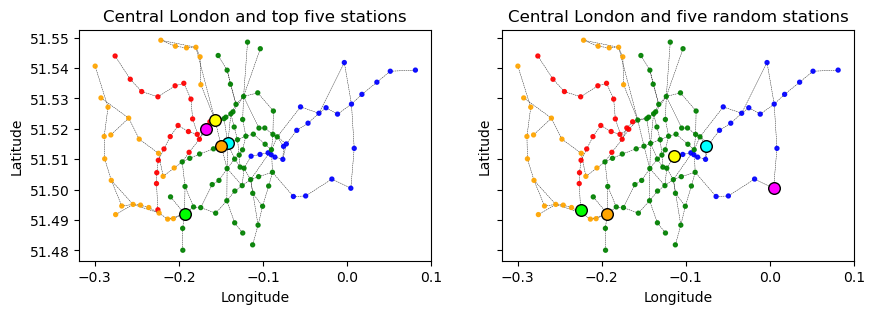

Graph used in Figure 6 of the report.


In [13]:
# Girvan–Newman communities (level 3)
communities = communities_level3

comm_index = {}
for i, comm in enumerate(communities):
    for n in comm:
        comm_index[n] = i

palette = ["red", "green", "blue", "orange", "purple", "cyan"]
node_colors = [palette[comm_index[n] % len(palette)] for n in G_central.nodes()]

pos = {n: (G_central.nodes[n]["lon"], G_central.nodes[n]["lat"]) for n in G_central.nodes()}

xs = [pos[n][0] for n in G_central.nodes()]
ys = [pos[n][1] for n in G_central.nodes()]

top5_nodes = [n for n, _ in top_5]
rand_nodes_gn = rand_nodes
top5_colors = ["yellow", "magenta", "cyan", "orange", "lime"]

# Create side‑by‑side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)

# 1. Top‑5 betweenness
for u, v in G_central.edges():
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    ax1.plot([x1, x2], [y1, y2],
             color="black", linewidth=0.3, linestyle="--", zorder=1)

ax1.scatter(xs, ys, s=8, c=node_colors, zorder=2, alpha=0.9)

handles1, labels1 = [], []
for node, color in zip(top5_nodes, top5_colors):
    x, y = pos[node]
    label = G_central.nodes[node].get("name", str(node))
    h = ax1.scatter(
        [x], [y],
        s=70, c=color,
        edgecolors="black", linewidths=1,
        zorder=3, label=label,
    )
    handles1.append(h)
    labels1.append(label)

ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title("Central London and top five stations")
ax1.set_aspect("auto")

# 2. Random‑5
for u, v in G_central.edges():
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    ax2.plot([x1, x2], [y1, y2],
             color="black", linewidth=0.3, linestyle="--", zorder=1)

ax2.scatter(xs, ys, s=8, c=node_colors, zorder=2, alpha=0.9)

handles2, labels2 = [], []
for node, color in zip(rand_nodes_gn, top5_colors):
    x, y = pos[node]
    label = G_central.nodes[node].get("name", str(node))
    h = ax2.scatter(
        [x], [y],
        s=70, c=color,
        edgecolors="black", linewidths=1,
        zorder=3, label=label,
    )
    handles2.append(h)
    labels2.append(label)

ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title("Central London and five random stations")
ax2.set_aspect("auto")

plt.show()

print("Graph used in Figure 6 of the report.")